# New York Movies Scene


In [1]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [2]:
df = pd.read_csv('Film_Permits.csv',skipinitialspace = True)
df = pd.DataFrame(df)
df.dropna(inplace=True)

In [3]:
# set date time format
df["StartDateTime"] = pd.to_datetime(df["StartDateTime"])
df["EndDateTime"] = pd.to_datetime(df["EndDateTime"])
df["EnteredOn"] = pd.to_datetime(df["EnteredOn"])

In [4]:
df['StartDateTime'] = pd.to_datetime(df['StartDateTime'])
df.sort_values(by='StartDateTime', inplace=True)

In [5]:
#clean CommunityBoard and PolicePrecinct
def setMean(columns):
    mean = []
    for cell in df[columns]:
    #     cell to string
        getCell = str(cell)
        #   if the first character is not a number remove it
        if getCell[0].isnumeric() == False:
            getCell = getCell[1:]
    #     cell to numpy array seperated by comma
        seperateCell = np.array(np.fromstring(getCell, dtype=int, sep=','))
    #     appaned mean
        mean.append(int(np.mean(seperateCell)))
    return mean

# clean Zipcodes
def setZip(code):
    postCode = []
    for zipcode in df['ZipCode(s)']:
        getZip = str(zipcode)
        # check if , is in the string
        if "," in getZip:
            # slicing off after length computation
            res = getZip[:getZip.index(',') + len(',') -1]
            postCode.append(int(res))
        else:
            postCode.append(int(getZip))
    return postCode

In [6]:

movie_scene = df
# remove spaces
movie_scene['CommunityBoard(s)'] = movie_scene['CommunityBoard(s)'].str.replace(' ','')
movie_scene['PolicePrecinct(s)'] = movie_scene['PolicePrecinct(s)'].str.replace(' ','')
# convert muitple CommunityBoard & PolicePrecinct to mean and set coloumn values as mean
movie_scene['CommunityBoard(s)'] =  setMean('CommunityBoard(s)')
movie_scene['PolicePrecinct(s)'] = setMean('PolicePrecinct(s)')
# convert multiple zipcodes to one zip code and replace zip code coloumn
movie_scene['ZipCode(s)'] = setZip('ZipCode(s)')
movie_scene.head()


,EventID,EventType,StartDateTime,EndDateTime,EnteredOn,EventAgency,ParkingHeld,Borough,CommunityBoard(s),PolicePrecinct(s),Category,SubCategoryName,Country,ZipCode(s)
6313,43257,Theater Load in and Load Outs,2012-01-01 06:00:00,2012-01-31 20:00:00,2011-12-29 11:40:41,"Mayor's Office of Film, Theatre & Broadcasting",WEST 48 STREET between 6 AVENUE and 7 AVENUE,Manhattan,5,18,Theater,Theater,United States of America,10036
23603,43053,Shooting Permit,2012-01-02 00:01:00,2012-01-02 23:59:00,2011-12-21 12:13:45,"Mayor's Office of Film, Theatre & Broadcasting",WEST 33 STREET between 6 AVENUE and 8 AVENUE...,Manhattan,4,14,Theater,Theater,United States of America,10001
10934,42737,Theater Load in and Load Outs,2012-01-02 06:00:00,2012-01-18 20:00:00,2011-12-15 14:06:52,"Mayor's Office of Film, Theatre & Broadcasting",WEST 46 STREET between 7 AVENUE and 8 AVENUE,Manhattan,5,18,Theater,Theater,United States of America,10036
8402,42926,Theater Load in and Load Outs,2012-01-02 06:00:00,2012-01-31 23:00:00,2011-12-19 14:05:39,"Mayor's Office of Film, Theatre & Broadcasting",WEST 46 STREET between 7 AVENUE and 6 AVENUE,Manhattan,5,18,Theater,Theater,United States of America,10036
27195,43264,Theater Load in and Load Outs,2012-01-02 06:00:00,2012-01-03 18:00:00,2011-12-29 14:40:59,"Mayor's Office of Film, Theatre & Broadcasting",ASHLAND PLACE between DEKALB AVENUE and FULTON...,Brooklyn,2,88,Theater,Theater,United States of America,11217


In [7]:
# group by StartDateTime
month = pd.DataFrame(movie_scene.groupby(pd.to_datetime(movie_scene['StartDateTime'])))

# get month name 
month = pd.DataFrame(month.groupby(month[0].dt.month_name()))

In [8]:
# pre covid numbers
# covid start date in the usa 
start_date = pd.to_datetime('1/1/2020')
# get movies where Category == Film
monthlyFilm = movie_scene.where(movie_scene['Category'] == 'Film').dropna()
# set date constraints
monthlyFilm.loc[(monthlyFilm['StartDateTime'] < start_date)]
# cound by month name
monthlyFilm = pd.DataFrame(monthlyFilm.groupby(pd.to_datetime(monthlyFilm['StartDateTime']).dt.month_name())['Category'].count())
monthlyFilm.rename(columns = {'Category':'pre-covid'}, inplace = True)

In [9]:
# get covid numbers 
# set dates 
start_date = pd.to_datetime('1/1/2020')
end_date = pd.Timestamp.today()
# get only films
monthlyCovidFilm = movie_scene.where(movie_scene['Category'] == 'Film').dropna()
# set date constraints
monthlyCovidFilm = monthlyCovidFilm.loc[(monthlyCovidFilm['StartDateTime'] > start_date) & (monthlyCovidFilm['StartDateTime'] <= end_date)]
# 
monthlyCovidFilm = pd.DataFrame(monthlyCovidFilm.groupby(pd.to_datetime(monthlyCovidFilm['StartDateTime']).dt.month_name())['Category'].count())
monthlyCovidFilm.rename(columns = {'Category':'post-covid'}, inplace = True)

In [25]:
totalFilm = pd.concat([monthlyFilm, monthlyCovidFilm], axis=1, join='inner')
# calculate percentage differnence
totalFilm['percentage of difference'] = ((totalFilm['pre-covid'] - totalFilm['post-covid']) / totalFilm['pre-covid']) * 100
totalFilm = totalFilm.reset_index()
totalFilm = totalFilm.rename(columns = {'StartDateTime':'month'})

In [27]:
# sort totalFilm by month 
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
# order months to above list
totalFilm.index = pd.CategoricalIndex(totalFilm['month'], categories=month_order,ordered=True)
# sort index
totalFilm = totalFilm.sort_index()
totalFilm

,month,pre-covid,post-covid,percentage of difference
month,,,,
January,January,360,19,94.722222
February,February,584,50,91.438356
March,March,724,44,93.922652
April,April,881,20,97.729852
May,May,1075,44,95.906977
June,June,1303,32,97.544129
July,July,1287,59,95.415695
August,August,1177,142,87.935429
September,September,989,98,90.091001


In [12]:
totalFilm['percentage of difference'].describe()

count    12.000000
mean     93.250867
std       3.258697
min      87.935429
25%      90.087335
50%      94.123488
75%      95.538516
max      97.729852
Name: percentage of difference, dtype: float64

# Total Filmings 
The above two table illustrate a numerical overview of the number of films shot during each month pre-covid and post-covid. The table also calculates the percentage of difference in the number of films shot before and during the pandemic. As we can see overall description of the percentage of difference. Pre-covid October had the most at *1310* which was dwindled down to *130* films post covid which is a **90%** decrease in films being shot. As for post pandemic, the highest month was August when *142* films were shot, while this is the high number as compared to pre- August numbers which only ranged in the tens this is still a stark decrease as compared to the same time pre-covid which saw shooting numbers at *1177*— a **88%** decrease.

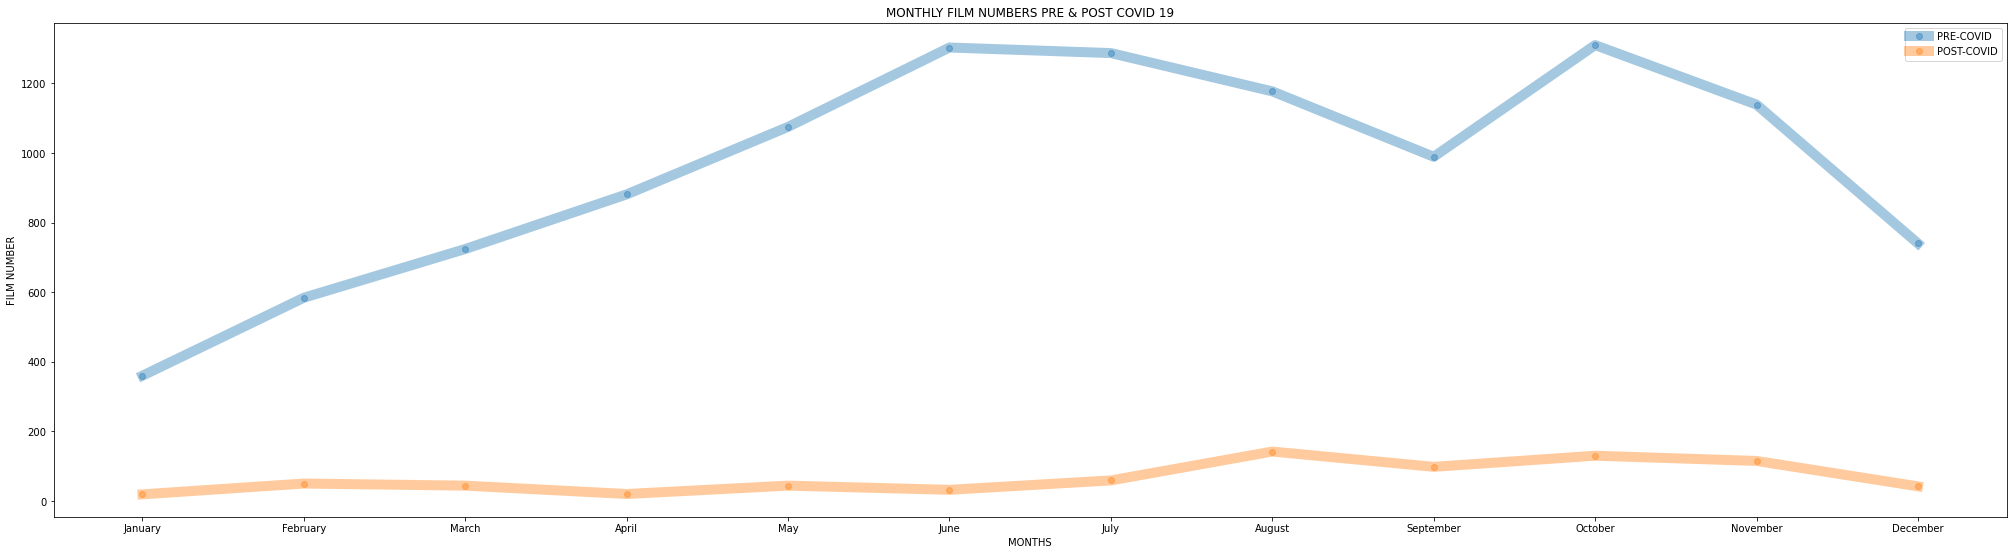

In [13]:
plt.rcParams['figure.figsize'] = (35,20)
plt.subplot(211)

preCovid = plt.plot_date(totalFilm['months'], totalFilm['pre-covid'], linestyle='solid', alpha=0.4, linewidth=10,label="PRE-COVID")
postCovid = plt.plot_date(totalFilm['months'], totalFilm['post-covid'], linestyle='solid', alpha=0.4, linewidth=10, label='POST-COVID')

leg = plt.legend(loc='upper right')
plt.xlabel('MONTHS')
plt.ylabel('FILM NUMBER')
plt.title('MONTHLY FILM NUMBERS PRE & POST COVID 19')
plt.show()

# MONTHLY FILM NUMBERS PRE & POST COVID 19
The plot above illustrates the drastic and overwhelming difference between the number of films shot before and during covid. This stark difference is extremely visible through out the graph especially from April – March. The reasons for this stark difference is twofold, one filming had  to be stopped due to lockdowns and two audiences couldn’t watch their moves hence the movie making budget was extremely low

In [14]:
overallDiration = movie_scene.groupby((movie_scene['EndDateTime'] - movie_scene['StartDateTime'])/ np.timedelta64(1, 'h')).count().reset_index()
# overallDiration.iloc[0]
overallDiration.rename(columns = {'index':'Duration'}, inplace = True)
overallDiration["Duration"] = overallDiration["Duration"].astype("float")
# remove films which took more than 50 days as they are outliers
overallDiration = pd.DataFrame(overallDiration.drop(np.where(overallDiration['Duration'] > 50)[0]))
overallDiration = pd.DataFrame(overallDiration.drop(np.where(overallDiration['Duration'] <= 0)[0]))
overallDiration = pd.DataFrame(overallDiration.drop(np.where(overallDiration['EventID'] <= 0)[0]))

overallDiration = overallDiration.dropna()

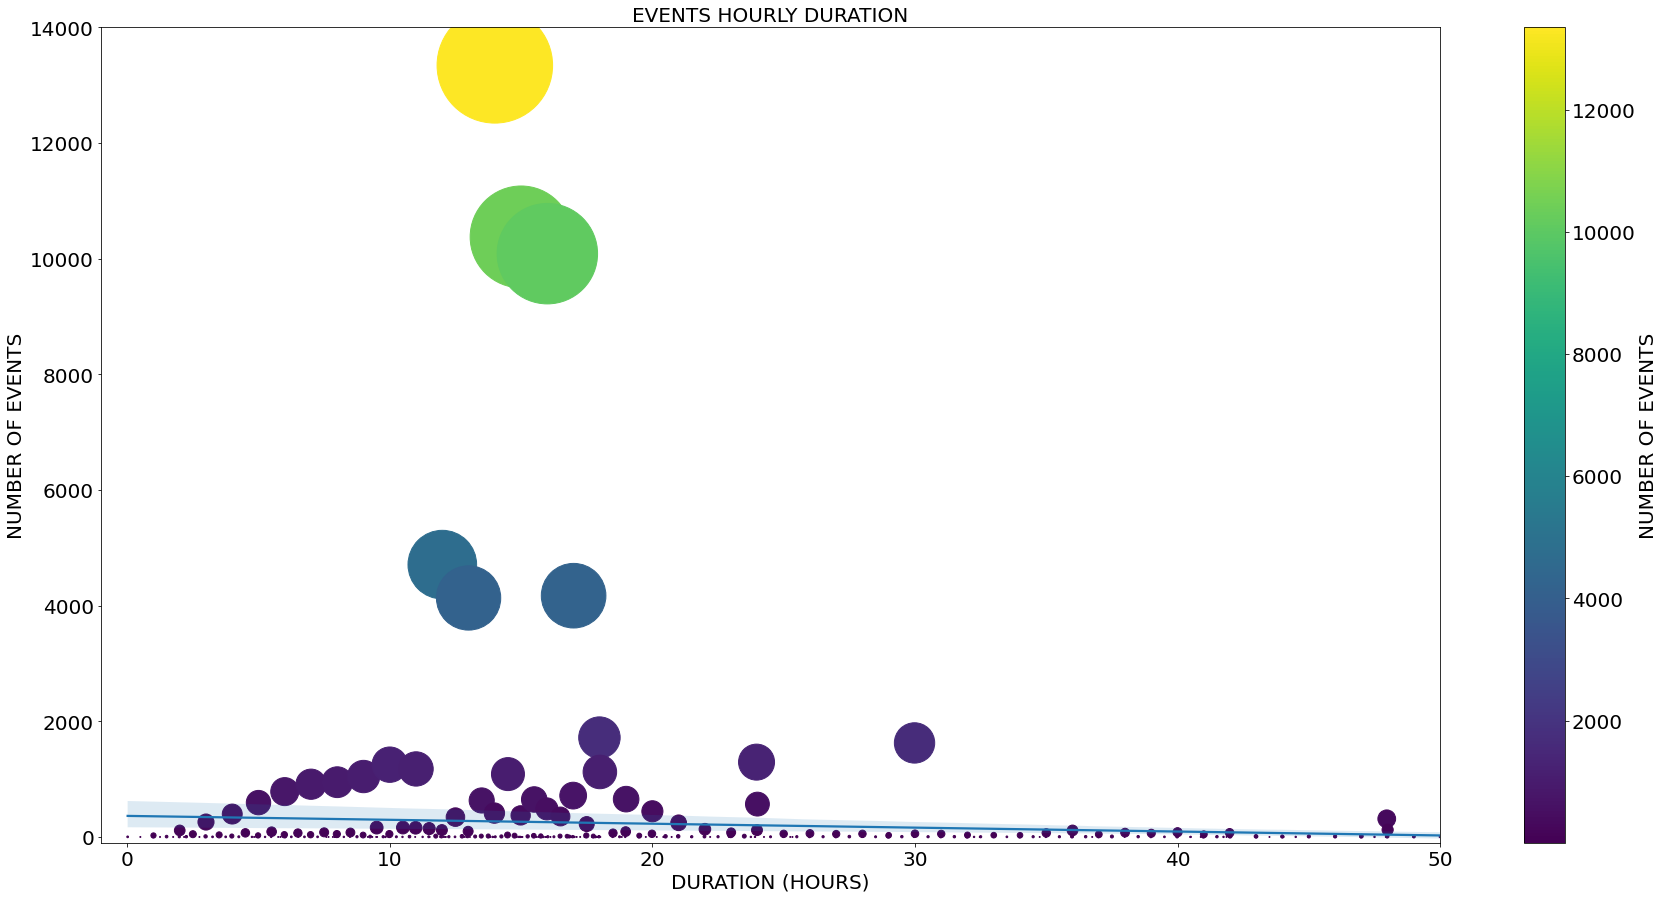

In [15]:
colors = np.random.rand(100)
plt.figure(figsize =(30, 15))
plt.rcParams.update({'font.size': 20})
plt.scatter(x = overallDiration['Duration'], y = overallDiration['EventID'], c=overallDiration['EventID'], s=overallDiration['EventID'])
cbar = plt.colorbar()
# add regression line
sns.regplot(x="Duration", y="EventID", data=overallDiration, marker='')
plt.xlim(-1,50)
plt.ylim(-100,14000)
plt.title("EVENTS HOURLY DURATION", fontsize=20,)
plt.xlabel('DURATION (HOURS)',fontsize=20,)
plt.ylabel('NUMBER OF EVENTS',fontsize=20,)
cbar.set_label('NUMBER OF EVENTS', fontsize=20,)

plt.show()


# Event Hourly Duration
The scatter plot above illustrates the number of events *i.e. every element sub-category in category* and counts the duration of said element. These elements are plotted on a plot where x is the duration (Duration in this case is the start date – end date) and y is the number of events, to further illustrate this as the number of events increases so does the colour and size of the point on the plot. For example, **14 thousand elements** have a duration between **10-20 hours** which makes this point big – the biggest in fact and yellow. To better show the information on the plot we have limited it to a max duration of 50 as to stop the plot being sued by outliers.

In [16]:
def findList(column,row):
    search = pd.DataFrame(movie_scene[[column]].where(movie_scene[column] == row)).dropna()
    result = search.groupby((movie_scene['EndDateTime'] - movie_scene['StartDateTime'])/ np.timedelta64(1, 'h')).count().reset_index()
    result.rename(columns = {'index':'Duration'}, inplace = True)
    return pd.DataFrame(result).dropna()

In [17]:
# movie_scene Borough
# get Borough and set duration and how many mediams within that Borough have the same duration
boroughManhattan = pd.DataFrame(findList('Borough','Manhattan'))
boroughQueens = pd.DataFrame(findList('Borough','Queens'))
boroughBrooklyn = pd.DataFrame(findList('Borough','Brooklyn'))
boroughBronx = pd.DataFrame(findList('Borough','Bronx'))
boroughStatenIsland = findList('Borough','Staten Island')
# get categories and set duration and how many mediams within that category have the same duration
categoryTelevision = pd.DataFrame(findList('Category','Television'))
categoryFilm = pd.DataFrame(findList('Category','Film'))
categoryPhotography = pd.DataFrame(findList('Category','Still Photography'))
categoryTheater = pd.DataFrame(findList('Category','Theater'))
categoryWEB = pd.DataFrame(findList('Category','WEB'))
categoryCommercial = pd.DataFrame(findList('Category','Commercial'))
categoryStudent = pd.DataFrame(findList('Category','Student'))
categoryDocumentary = pd.DataFrame(findList('Category','Documentary'))
categoryMusic = pd.DataFrame(findList('Category','Music Video'))
categoryRedCarpet = pd.DataFrame(findList('Category','Red Carpet/Premiere'))

In [18]:
# get the top 20 most frequent movie times
boroughManhattan = boroughManhattan.nlargest(n=20, columns=['Borough','Duration'])
boroughQueens = boroughQueens.nlargest(n=20, columns=['Borough','Duration'])
boroughBrooklyn = boroughBrooklyn.nlargest(n=20, columns=['Borough','Duration'])
boroughBronx = boroughBronx.nlargest(n=20, columns=['Borough','Duration'])
boroughStatenIsland = boroughStatenIsland.nlargest(n=20, columns=['Borough','Duration'])
# top 20 categories 
categoryTelevision = categoryTelevision.nlargest(n=20, columns=['Category','Duration'])
categoryFilm = categoryFilm.nlargest(n=20, columns=['Category','Duration'])
categoryPhotography = categoryPhotography.nlargest(n=20, columns=['Category','Duration'])
categoryTheater = categoryTheater.nlargest(n=20, columns=['Category','Duration'])
categoryWEB = categoryWEB.nlargest(n=20, columns=['Category','Duration'])
categoryCommercial = categoryCommercial.nlargest(n=20, columns=['Category','Duration'])
categoryStudent = categoryStudent.nlargest(n=20, columns=['Category','Duration'])
categoryDocumentary = categoryDocumentary.nlargest(n=20, columns=['Category','Duration'])
categoryMusic = categoryMusic.nlargest(n=20, columns=['Category','Duration'])
categoryRedCarpet = categoryRedCarpet.nlargest(n=500, columns=['Category','Duration'])

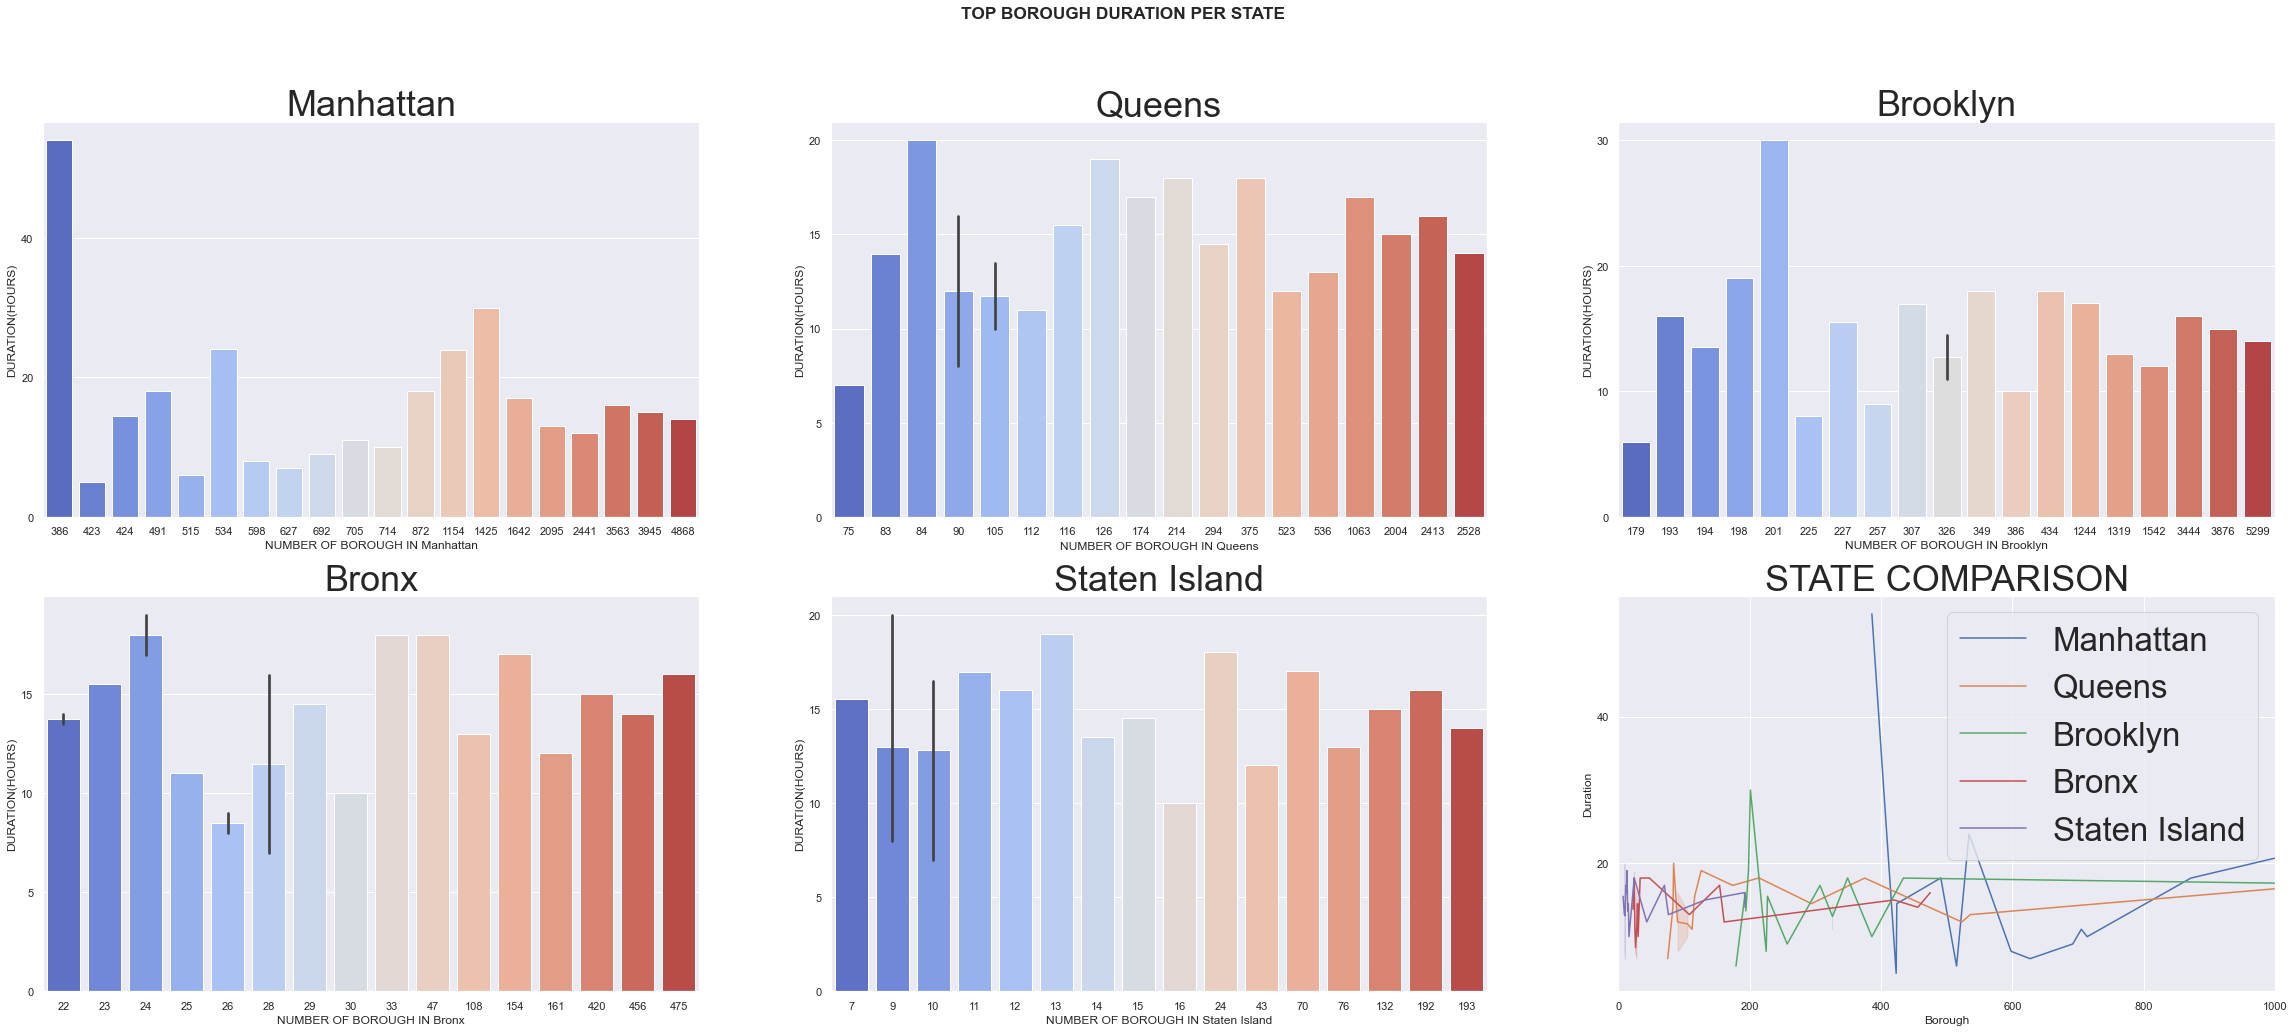

In [19]:
sns.set(rc={"figure.figsize":(40, 16)}) #width=3, #height=4
fig, axes = plt.subplots(2, 3)
fig.suptitle("TOP BOROUGH DURATION PER STATE" ,
               fontsize = 'x-large' , 
               fontweight = 'bold' )
sns.set(font_scale=3)
sns.barplot(data=boroughManhattan, x="Borough", y="Duration", palette ='coolwarm',ax=axes[0,0]).set(xlabel ="NUMBER OF BOROUGH IN Manhattan", ylabel = "DURATION(HOURS)", title ='Manhattan')
sns.barplot(data=boroughQueens, x="Borough", y="Duration",palette ='coolwarm',ax=axes[0,1]).set(xlabel ="NUMBER OF BOROUGH IN Queens", ylabel = "DURATION(HOURS)", title ='Queens')
sns.barplot(data=boroughBrooklyn, x="Borough", y="Duration", palette ='coolwarm',ax=axes[0,2]).set(xlabel ="NUMBER OF BOROUGH IN Brooklyn", ylabel = "DURATION(HOURS)", title ='Brooklyn')
sns.barplot(data=boroughBronx, x="Borough", y="Duration", palette ='coolwarm',ax=axes[1,0]).set(xlabel ="NUMBER OF BOROUGH IN Bronx", ylabel = "DURATION(HOURS)", title ='Bronx')
sns.barplot(data=boroughStatenIsland, x="Borough", y="Duration", palette ='coolwarm',ax=axes[1,1]).set(xlabel ="NUMBER OF BOROUGH IN Staten Island", ylabel = "DURATION(HOURS)", title ='Staten Island')
# compare graphs
ax = sns.lineplot(data=boroughManhattan, x="Borough", y="Duration",ax=axes[1,2], label='Manhattan')
ax = sns.lineplot(data=boroughQueens, x="Borough", y="Duration",ax=axes[1,2], label='Queens')
ax = sns.lineplot(data=boroughBrooklyn, x="Borough", y="Duration",ax=axes[1,2], label='Brooklyn')
ax = sns.lineplot(data=boroughBronx, x="Borough", y="Duration",ax=axes[1,2], label='Bronx')
ax = sns.lineplot(data=boroughStatenIsland, x="Borough", y="Duration",ax=axes[1,2], label='Staten Island')
ax.set(xlim=(0, 1000))
ax.set(title='STATE COMPARISON')
# ax.set(ylim=(0, 50))
plt.show()

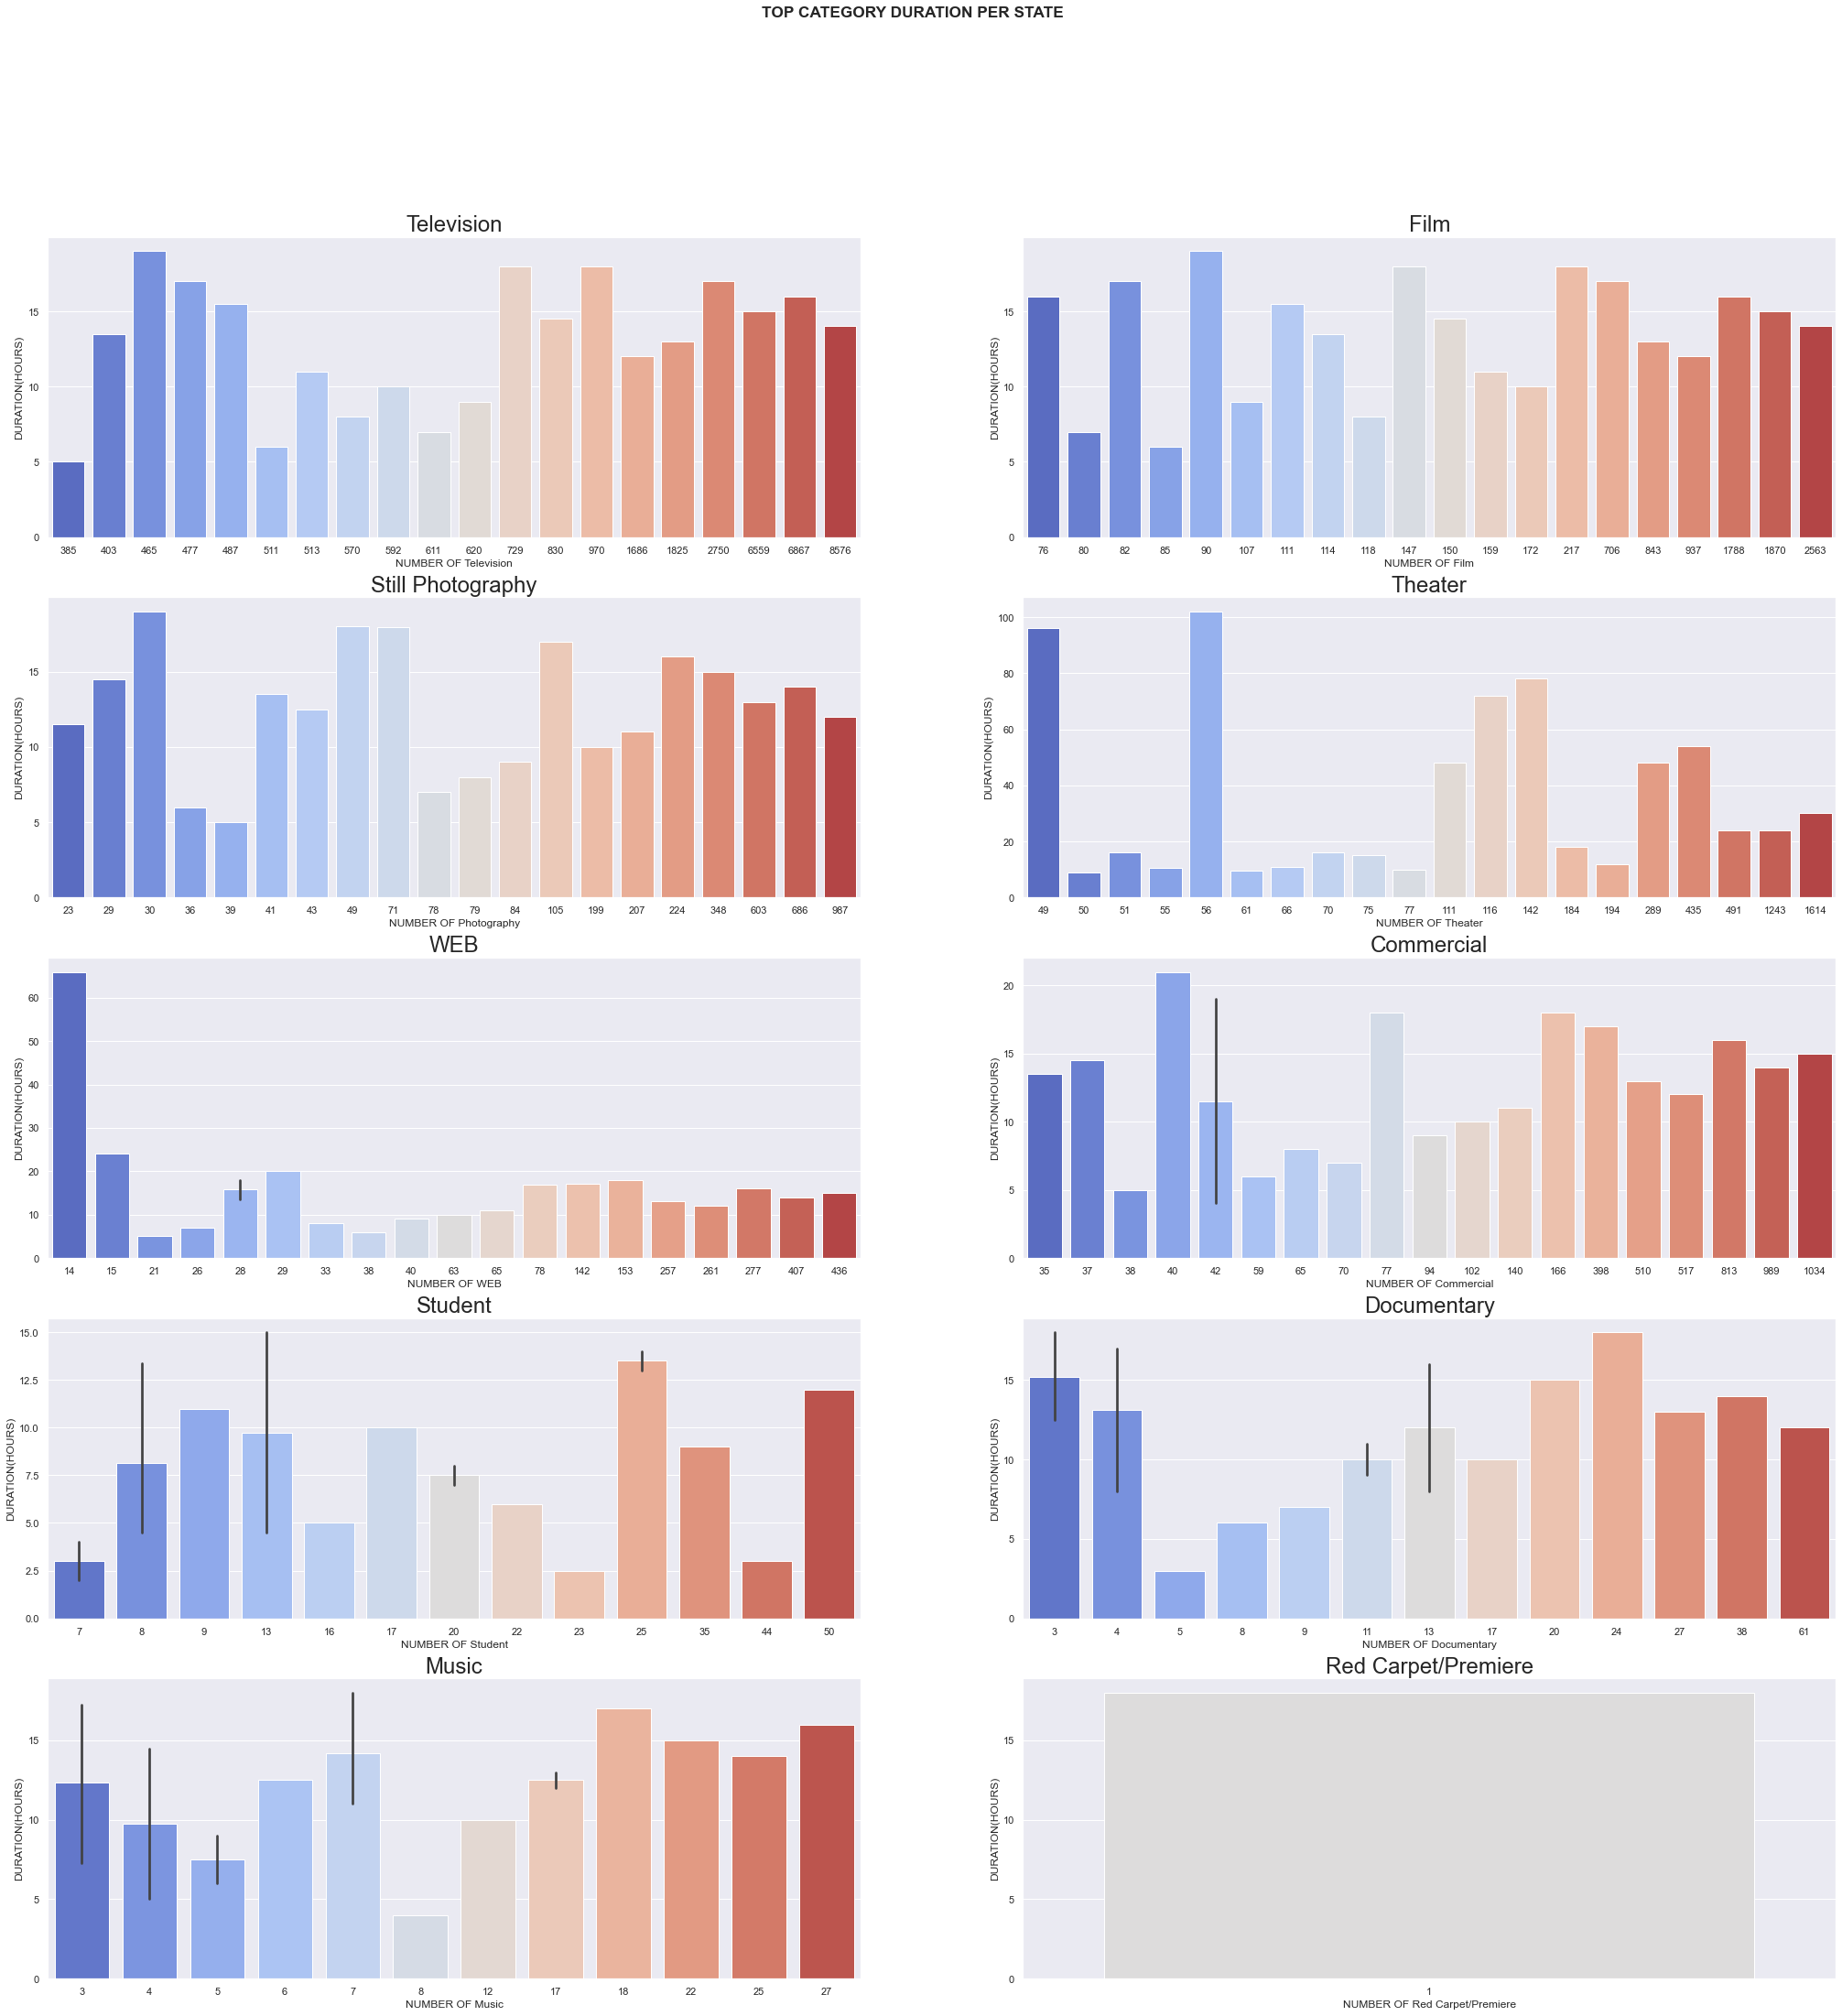

In [20]:
sns.set(rc={"figure.figsize":(35, 35)}) #width=3, #height=4
fig, axes = plt.subplots(5, 2)
fig.suptitle("TOP CATEGORY DURATION PER STATE" ,
               fontsize = 'x-large' , 
               fontweight = 'bold' )
sns.set(font_scale=2)
sns.barplot(data=categoryTelevision, x="Category", y="Duration", palette ='coolwarm',ax=axes[0,0]).set(xlabel ="NUMBER OF Television", ylabel = "DURATION(HOURS)", title ='Television')
sns.barplot(data=categoryFilm, x="Category", y="Duration", palette ='coolwarm',ax=axes[0,1]).set(xlabel ="NUMBER OF Film", ylabel = "DURATION(HOURS)", title ='Film')
sns.barplot(data=categoryPhotography, x="Category", y="Duration", palette ='coolwarm',ax=axes[1,0]).set(xlabel ="NUMBER OF Photography", ylabel = "DURATION(HOURS)", title ='Still Photography')
sns.barplot(data=categoryTheater, x="Category", y="Duration", palette ='coolwarm',ax=axes[1,1]).set(xlabel ="NUMBER OF Theater", ylabel = "DURATION(HOURS)", title ='Theater')
sns.barplot(data=categoryWEB, x="Category", y="Duration", palette ='coolwarm',ax=axes[2,0]).set(xlabel ="NUMBER OF WEB", ylabel = "DURATION(HOURS)", title ='WEB')
sns.barplot(data=categoryCommercial, x="Category", y="Duration", palette ='coolwarm',ax=axes[2,1]).set(xlabel ="NUMBER OF Commercial", ylabel = "DURATION(HOURS)", title ='Commercial')
sns.barplot(data=categoryStudent, x="Category", y="Duration", palette ='coolwarm',ax=axes[3,0]).set(xlabel ="NUMBER OF Student", ylabel = "DURATION(HOURS)", title ='Student')
sns.barplot(data=categoryDocumentary, x="Category", y="Duration", palette ='coolwarm',ax=axes[3,1]).set(xlabel ="NUMBER OF Documentary", ylabel = "DURATION(HOURS)", title ='Documentary')
sns.barplot(data=categoryMusic, x="Category", y="Duration", palette ='coolwarm',ax=axes[4,0]).set(xlabel ="NUMBER OF Music", ylabel = "DURATION(HOURS)", title ='Music')
sns.barplot(data=categoryRedCarpet, x="Category", y="Duration", palette ='coolwarm',ax=axes[4,1]).set(xlabel ="NUMBER OF Red Carpet/Premiere", ylabel = "DURATION(HOURS)", title ='Red Carpet/Premiere')
plt.show()

In [21]:
cc = movie_scene.groupby(movie_scene['Category']).count()
cc

,EventID,EventType,StartDateTime,EndDateTime,EnteredOn,EventAgency,ParkingHeld,Borough,CommunityBoard(s),PolicePrecinct(s),SubCategoryName,Country,ZipCode(s)
Category,,,,,,,,,,,,,
Commercial,5823,5823,5823,5823,5823,5823,5823,5823,5823,5823,5823,5823,5823
Documentary,337,337,337,337,337,337,337,337,337,337,337,337,337
Film,11569,11569,11569,11569,11569,11569,11569,11569,11569,11569,11569,11569,11569
Music Video,249,249,249,249,249,249,249,249,249,249,249,249,249
Red Carpet/Premiere,1,1,1,1,1,1,1,1,1,1,1,1,1
Still Photography,4319,4319,4319,4319,4319,4319,4319,4319,4319,4319,4319,4319,4319
Student,444,444,444,444,444,444,444,444,444,444,444,444,444
Television,41777,41777,41777,41777,41777,41777,41777,41777,41777,41777,41777,41777,41777
Theater,7160,7160,7160,7160,7160,7160,7160,7160,7160,7160,7160,7160,7160


In [22]:
# crimeDescription = movie_scene['Category'].unique()
# crimeDescription

In [23]:
# categoryDuration = pd.DataFrame()

# def duration(categoryName):
#     category = pd.DataFrame(movie_scene.where(movie_scene['Category'] == categoryName).dropna())
#     category = pd.DataFrame(category)
#     days
#     for cell in range(len(category)):
#         duration = category['EndDateTime'].iloc[cell] - category['StartDateTime'].iloc[cell]
#         days += duration
#     return days

# duration('Television')

In [24]:
boroughValues = movie_scene['Category'].unique()
boroughValues

array(['Theater', 'Television', 'Film', 'WEB', 'Commercial', 'Student',
       'Still Photography', 'Documentary', 'Music Video',
       'Red Carpet/Premiere'], dtype=object)